In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from learner import *

d:\Machine Learning\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [4]:
# new conv
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=norm, bias=True), 
        nn.Flatten()
    )

model = get_model(norm=nn.BatchNorm2d)

In [5]:
lr = 0.001
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy
0	train	1.0044	0.7390
0	test	0.7633	0.8180
1	train	0.7257	0.8363
1	test	0.6585	0.8479
2	train	0.6469	0.8592
2	test	0.6069	0.8595
3	train	0.5932	0.8744
3	test	0.5640	0.8703
4	train	0.5526	0.8855
4	test	0.5333	0.8771


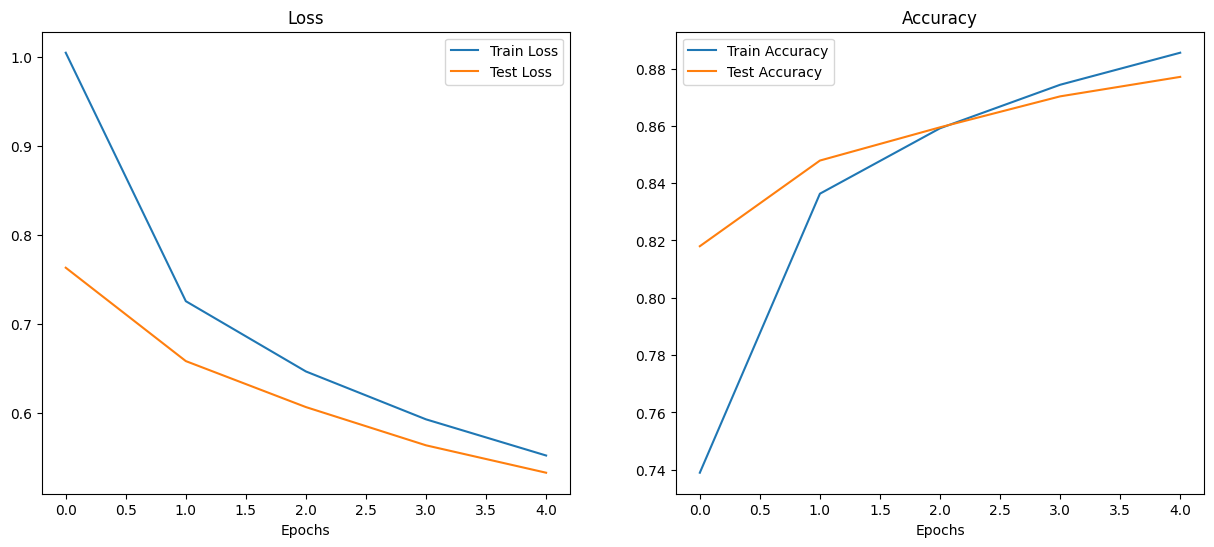

In [6]:
learn = Learner(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)
learn.fit(epochs)